<a href="https://colab.research.google.com/github/UERJ-FISICA/ML4PPGF_UERJ/blob/PPGF-2023-2/Classifica%C3%A7%C3%A3o_Fashion_CNN_WideResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from joblib import dump, load

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

sklearn: 1.2.2
tensorflow: 2.13.0


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

print ( gpus )

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
train_model = True
save_model = True

model_path = ""
scaler_path = ""
if not train_model:
    model_path = "keras_model.h5"
    scaler_path = "standard_scaler.joblib"

### Amostra FASHION MNIST

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:10000], X_train_full[10000:]
y_valid, y_train = y_train_full[:10000], y_train_full[10000:]

tf.random.set_seed(42)
np.random.seed(42)

print ( X_train.shape )
print ( X_valid.shape )
print ( X_test.shape )

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


In [ ]:
X_train = X_train.reshape( (len(X_train),28,28,1) )
print( X_train.shape )
X_valid = X_valid.reshape( (len(X_valid),28,28,1) )
print( X_valid.shape )
X_test = X_test.reshape( (len(X_test),28,28,1) )
print( X_test.shape )

X_mean = X_train.mean( axis=0 )
X_std = X_train.std( axis=0 )
X_train_scaled = ( X_train - X_mean ) / X_std
X_valid_scaled = ( X_valid - X_mean ) / X_std
X_test_scaled  = ( X_test - X_mean ) / X_std
X_train_scaled[10]

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


array([[[-0.00714939],
        [-0.02259701],
        [-0.04749068],
        [-0.04039468],
        [-0.05683006],
        [-0.07010959],
        [-0.09760359],
        [-0.15513164],
        [-0.23893762],
        [-0.37952352],
        [-0.57053077],
        [-0.694674  ],
        [-0.75900494],
        [-0.74973597],
        [-0.74937949],
        [-0.7751858 ],
        [-0.75745513],
        [-0.64652364],
        [-0.50360013],
        [-0.31979054],
        [-0.20224307],
        [-0.13951541],
        [-0.10889008],
        [-0.09206532],
        [-0.06849855],
        [-0.0507646 ],
        [-0.03324326],
        [-0.01443135]],

       [[-0.01230748],
        [-0.0168835 ],
        [-0.03319486],
        [-0.05559106],
        [-0.07714261],
        [-0.13124202],
        [-0.24326328],
        [-0.36492659],
        [-0.48893735],
        [-0.6445122 ],
        [-0.8337121 ],
        [-1.00353902],
        [-1.09301419],
        [-1.0837614 ],
        [-1.06800491],
        [

In [ ]:
print ( y_train )

[8 7 6 ... 3 0 5]


In [ ]:
import keras.utils

number_of_classes = 10
y_train_cat = keras.utils.to_categorical(y_train, number_of_classes)
y_valid_cat = keras.utils.to_categorical(y_valid, number_of_classes)
y_test_cat = keras.utils.to_categorical(y_test, number_of_classes)
# y_train_cat = keras.utils.np_utils.to_categorical(y_train, number_of_classes)
# y_valid_cat = keras.utils.np_utils.to_categorical(y_valid, number_of_classes)
# y_test_cat = keras.utils.np_utils.to_categorical(y_test, number_of_classes)

idx=1000
y_train[idx], y_train_cat[idx]

(8, array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32))

8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.] Bag


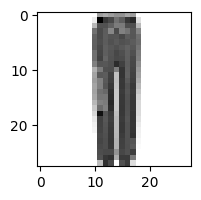

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

print ( y_train[ idx ], y_train_cat[ idx ], class_names[ y_train[ idx ] ] )

fig = plt.figure( figsize=(2,2) )
plt.imshow( X_valid[ idx ], cmap='binary' )

### Treinamento

In [ ]:
# shuffle_index = np.random.permutation( 50000 )
# X_train_shuffle, y_train_shuffle, y_train_cat_shuffle = X_train[ shuffle_index ], y_train[ shuffle_index ], y_train_cat[ shuffle_index ]

### Definição do modelo

In [ ]:
from wideresnet import WideResidualNetwork
# from novograd import NovoGrad

class Model:
    def __init__(self, input_shape, learning_rate):
        self.input_shape = input_shape
        self.learning_rate = learning_rate

    def __call__(self, num_classes, dropout, weight_decay=5e-06):

        input_shape = self.input_shape
        learning_rate = self.learning_rate

        print( "Building model with:" )
        print( "Input shape: {}".format(input_shape) )
        print( "Learning rate: {}".format(learning_rate) )
        print( "Dropout rate: {}".format(dropout) )

        # Set up standard WideResNet-16-10 model.
        model = WideResidualNetwork( depth=16, width=10, input_shape=input_shape,
                                     classes=num_classes, dropout_rate=dropout )

        # WideResNet model that is included with Keras is optimized for inference.
        # Add L2 weight decay & adjust BN settings.
        model_config = model.get_config()
        for layer, layer_config in zip(model.layers, model_config['layers']):
            if hasattr(layer, 'kernel_regularizer'):
                regularizer = keras.regularizers.l2( weight_decay )
                layer_config['config']['kernel_regularizer'] = \
                    {'class_name': regularizer.__class__.__name__,
                     'config': regularizer.get_config()}
            if type(layer) == keras.layers.BatchNormalization:
                layer_config['config']['momentum'] = 0.9
                layer_config['config']['epsilon'] = 1e-5

        model = keras.models.Model.from_config( model_config )

        #opt = keras.optimizers.SGD(lr=base_lr, momentum=momentum)
        #opt = keras.optimizers.Adam(lr=lr_init, epsilon=1.e-5)
        #opt = keras.optimizers.SGD(lr=lr_init * hvd.size())
        #opt = NovoGrad(learning_rate=lr_init * hvd.size())
        opt = keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1.e-5)
        # opt = tf.optimizers.Adam(learning_rate=learning_rate, epsilon=1.e-5)

        model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                      optimizer=opt,
                      metrics=['accuracy'],
                      experimental_run_tf_function = False)

        return model

def build_model(input_shape, learning_rate=5e-4, num_classes=10, dropout=0.10 ):
    build_fn_ = Model( input_shape=input_shape, learning_rate=learning_rate )
    return build_fn_( num_classes, dropout )


### Callbacks

In [ ]:
# Define a function for a simple learning rate decay over time
class LRScheduler:
    def __init__( self, lr_init ):
        self.lr_init = lr_init
    def __call__( self, epoch ):
        if epoch < 10:
            return self.lr_init
        if epoch < 15:
            return 1e-1 * self.lr_init
        if epoch < 25:
            return 1e-2 * self.lr_init
        return 1e-3 * self.lr_init

lr_scheduler_ = LRScheduler( lr_init=1e-02 )

class ExponentialDecayLR:
    def __init__( self, lr0, s ):
        self.lr0 = lr0
        self.s = s
    def __call__( self, epoch ):
        return self.lr0 * 0.1**( epoch / self.s )

exponential_decay_ = ExponentialDecayLR( lr0=1e-2, s=10 )

In [ ]:
import os
import time

verbose = False

class PrintThroughput(keras.callbacks.Callback):
    def __init__(self, total_images=0):
        self.total_images = total_images

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        epoch_time = time.time() - self.epoch_start_time
        images_per_sec = round( self.total_images / epoch_time, 2 )
        print('\nImages/sec: {}'.format(images_per_sec))

class PrintTotalTime(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        total_time = round( time.time() - self.start_time, 2 )
        print( "Cumulative training time after epoch {}: {}".format(epoch + 1, total_time) )

    def on_train_end(self, logs=None):
        total_time = round( time.time() - self.start_time, 2 )
        print( "Cumulative training time: {}".format(total_time) )

def get_run_logdir(log_dir):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(log_dir, run_id)

def callbacks(patience=5, lr_scheduler_fn=None, log_dir=None):
    callbacks_ = []
    # Early stopping
    if patience > 0:
        early_stopping_cb_ = keras.callbacks.EarlyStopping( patience=patience, restore_best_weights=True )
        callbacks_.append( early_stopping_cb_ )

    # Learning rate exponential decay
    if lr_scheduler_fn:
        lr_scheduler_cb_ = keras.callbacks.LearningRateScheduler( lr_scheduler_fn )
        callbacks_.append( lr_scheduler_cb_ )

    if verbose:
        callbacks_.append( PrintThroughput( total_images=len(y_train) ) )

    if verbose:
        callbacks_.append( PrintTotalTime() )

    # TensorBoard
    if log_dir:
        run_logdir = get_run_logdir(log_dir)
        print ( "Log dir: {}".format(run_logdir) )
        tensorboard_cb_ = keras.callbacks.TensorBoard( run_logdir )
        callbacks_.append( tensorboard_cb_ )

    return callbacks_


In [ ]:
# Trainign batch size
batch_size = 32
# Number of training epochs
epochs = 10
# Learning rate
lr = 5e-4
# callbacks_ = callbacks( patience=5, lr_scheduler_fn=lr_scheduler_ )
callbacks_ = callbacks( patience=5, lr_scheduler_fn=exponential_decay_ )

model = build_model( (28,28,1), learning_rate=lr, num_classes=10, dropout=0.10 )
model.summary()

Building model with:
Input shape: (28, 28, 1)
Learning rate: 0.0005
Dropout rate: 0.1
Model: "wide-resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 16)           160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 a

In [ ]:
generate_images = True
if generate_images:
    from tensorflow.keras.preprocessing import image
    # Training data iterator
    # train_gen = image.ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,
    #                                      horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2)
    train_gen = image.ImageDataGenerator( horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2, rotation_range=5 )
    X_train__ = X_train_scaled
    # X_train__ = X_train
    train_gen.fit( X_train__ )
    train_iter = train_gen.flow(X_train__, y_train, batch_size=batch_size)

    # Validation data iterator
    X_valid__ = X_valid_scaled
    # X_valid__ = X_valid
    # valid_gen = image.ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
    valid_gen = image.ImageDataGenerator()
    valid_gen.mean = train_gen.mean
    valid_gen.std = train_gen.std
    valid_iter = valid_gen.flow(X_valid__, y_valid, batch_size=batch_size)

In [ ]:
help(image.ImageDataGenerator)

Help on class ImageDataGenerator in module keras.src.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |  Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
 |  recommended for new code. Prefer loading images with
 |  `tf.keras.utils.image_dataset_from_directory` and transforming the output
 |  `tf.data.Dataset` with preprocessing layers. For more infor

[[[-3.35083395e-01]
  [-3.73238444e-01]
  [-1.81745946e-01]
  [ 1.81891531e-01]
  [ 7.12382853e-01]
  [ 9.73559856e-01]
  [ 6.34400368e-01]
  [ 2.77716398e-01]
  [ 3.99758101e-01]
  [ 7.01166034e-01]
  [ 1.94209874e-01]
  [-3.89046580e-01]
  [-1.26484269e-02]
  [ 1.69621214e-01]
  [ 5.40488474e-02]
  [-2.12314934e-01]
  [-5.57936609e-01]
  [-4.22251284e-01]
  [-2.93625027e-01]
  [-1.99375555e-01]
  [-1.45817608e-01]
  [-9.75463092e-02]
  [-6.02076314e-02]
  [-5.92904910e-02]
  [-5.83733469e-02]
  [-5.74562028e-02]
  [-5.65390587e-02]
  [-5.56219183e-02]]

 [[-3.40897232e-01]
  [ 3.58661890e-01]
  [ 8.97494853e-01]
  [ 7.19227791e-01]
  [ 3.89853299e-01]
  [-7.18503669e-02]
  [-1.57951564e-01]
  [ 3.33849430e-01]
  [-9.44429860e-02]
  [ 6.89687848e-01]
  [ 9.13545787e-02]
  [-3.31677139e-01]
  [-8.18675235e-02]
  [-6.76886588e-02]
  [ 9.22800042e-03]
  [ 2.63057381e-01]
  [-1.01479543e-02]
  [-3.91442865e-01]
  [-3.84295583e-01]
  [-2.64989227e-01]
  [-1.91385970e-01]
  [-1.31236747e-01

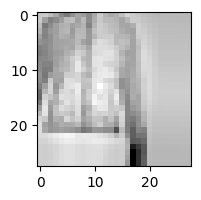

In [ ]:
X__, y__ = train_iter.next()
X__ = X__[0]
y__ = y__[0]
print ( X__, y__ )

fig = plt.figure( figsize=(2,2) )
plt.imshow( X__, cmap='binary' )

In [ ]:
if generate_images:
    history = model.fit(
        train_iter,
        steps_per_epoch=10*len(train_iter),
        callbacks=callbacks_,
        epochs=epochs,
        workers=4,
        # validation_data=valid_iter,
        # validation_steps=10*len(valid_iter)
        validation_data=(X_valid_scaled, y_valid)
        )
else:
    history = model.fit( X_train_scaled, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks_, workers=4 )
    # history = model.fit( X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid), callbacks=callbacks_, workers=4 )

Epoch 1/10
15630/15630 [==============================] - 1462s 92ms/step - loss: 0.9805 - accuracy: 0.7711 - val_loss: 0.6336 - val_accuracy: 0.8304 - lr: 0.0100
Epoch 2/10
15630/15630 [==============================] - 1412s 90ms/step - loss: 0.5405 - accuracy: 0.8481 - val_loss: 0.4008 - val_accuracy: 0.8923 - lr: 0.0079
Epoch 3/10
15630/15630 [==============================] - 1408s 90ms/step - loss: 0.4657 - accuracy: 0.8666 - val_loss: 0.3832 - val_accuracy: 0.8966 - lr: 0.0063
Epoch 4/10
15630/15630 [==============================] - 1403s 90ms/step - loss: 0.4230 - accuracy: 0.8780 - val_loss: 0.3392 - val_accuracy: 0.9059 - lr: 0.0050
Epoch 5/10
15630/15630 [==============================] - 1432s 92ms/step - loss: 0.3844 - accuracy: 0.8879 - val_loss: 0.3285 - val_accuracy: 0.9135 - lr: 0.0040
Epoch 6/10
15630/15630 [==============================] - 1405s 90ms/step - loss: 0.3558 - accuracy: 0.8947 - val_loss: 0.3020 - val_accuracy: 0.9139 - lr: 0.0032
Epoch 7/10
15630/15630

In [ ]:
score = model.evaluate( X_valid_scaled, y_valid )
# score = model.evaluate( X_valid, y_valid )
print( score )

In [ ]:
score = model.evaluate( X_test_scaled, y_test )
# score = model.evaluate( X_test, y_test )
print( score )

In [ ]:
fig, axes = plt.subplots( 1, 2, figsize=(16,6) )
axes[0].plot( history.epoch, history.history['accuracy'], 'o-', label="Train" )
axes[0].plot( history.epoch, history.history['val_accuracy'], 'o-', label="Valid." )
axes[1].plot( history.epoch, history.history['loss'], 'o-', label="Train" )
axes[1].plot( history.epoch, history.history['val_loss'], 'o-', label="Valid." )
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend( loc='best' )
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend( loc='best' )

In [ ]:
y_test_proba = model.predict( X_test_scaled )
# y_test_proba = model.predict( X_test )
print ( y_test_proba )
y_test_pred = np.argmax( y_test_proba, axis=-1 )
print ( y_test_pred )

In [ ]:
accuracy = np.sum( y_test_pred == y_test ) / y_test.size
print ( "Accuracy = {}".format( accuracy ) )

In [ ]:
def plot_images( X, n, start = 0 ):
    n_per_row_ = 10
    n_rows_ = int( ( n / n_per_row_  ) if ( n % n_per_row_ ) == 0 else ( ( n // n_per_row_ ) + 1 ) )
    size_ = 5
    fig_, axes_ = plt.subplots( n_rows_, n_per_row_, figsize=( n_per_row_ * size_ , n_rows_ * size_ ) )
    idx_row_, idx_col_ = 0, 0
    for idx__ in range( n ):
        if idx__ >= len( X ): break

        ax_ = axes_[ idx_row_, idx_col_ ]
        ax_.imshow( X[ start+idx__ ], cmap='binary' )
        idx_col_ += 1
        if idx_col_ % n_per_row_ == 0:
            idx_row_ += 1
            idx_col_  = 0

msk_error_ = y_test_pred != y_test
print ( np.sum( msk_error_ ) )
for label_ in range( 10 ):
    msk__ = msk_error_ & ( y_test == label_ )
    print ( "{} ({}): {}".format( class_names[label_], label_, np.sum( msk__ ) ) )

msk_pred_Sneaker_ = y_test_pred == 7

# plot_images( X_test[ msk_error_ ], 100 )
plot_images( X_test[ msk_pred_Sneaker_ ], 100 )